<a href="https://colab.research.google.com/github/KenichiQaz/ML_Learning/blob/main/Own_Try_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet

## Data

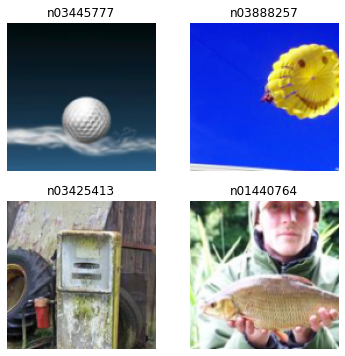

In [9]:
from fastai.vision.all import *

def get_data(url, presize, resize):
    path = untar_data(url)
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock), get_items=get_image_files, 
        splitter=GrandparentSplitter(valid_name='val'),
        get_y=parent_label, item_tfms=Resize(presize),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                    Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs=128)

dls = get_data(URLs.IMAGENETTE_160, 160, 128)
dls.show_batch(max_n=4)

## Convolutional network

In [10]:
def block(ni, nf): return ConvLayer(ni, nf, stride=2)
def get_model():
    return nn.Sequential(
        block(3, 16),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, dls.c))

SuggestedLRs(valley=0.0006918309954926372)

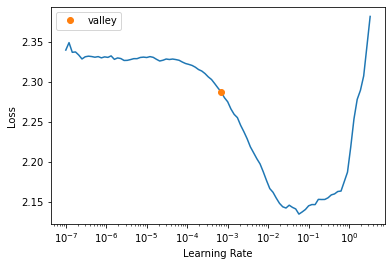

In [11]:
def get_learner(m):
    return Learner(dls, m, loss_func=nn.CrossEntropyLoss(), metrics=accuracy
                  ).to_fp16()

learn = get_learner(get_model())
learn.lr_find()

In [12]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.857499,2.239846,0.354140,00:27
1,1.517755,2.105251,0.389809,00:27
2,1.303146,1.188060,0.612484,00:27
3,1.144651,1.213336,0.618344,00:27
4,1.048730,1.080288,0.654777,00:27


In [13]:
def _conv_block(ni,nf,stride):
    return nn.Sequential(
        ConvLayer(ni, nf, stride=stride),
        ConvLayer(nf, nf, act_cls=None, norm_type=NormType.BatchZero))

In [14]:
class ResBlock(Module):
    def __init__(self, ni, nf, stride=1):
        self.convs = _conv_block(ni,nf,stride)
        self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
# noop is a computer science term that stands for "no operation"
    def forward(self, x):
        return F.relu(self.convs(x) + self.idconv(self.pool(x)))

In [15]:
def block(ni, nf):
    return nn.Sequential(ResBlock(ni, nf, stride=2), ResBlock(nf, nf))
learn = get_learner(get_model())
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.935049,2.053832,0.326115,00:31
1,1.620069,1.678823,0.466242,00:29
2,1.316259,1.346372,0.568917,00:29
3,1.103869,0.955799,0.688153,00:29
4,0.953554,0.953942,0.696561,00:29


# A State-of-the-Art ResNet

In [16]:
def _resnet_stem(*sizes):
    return [
        ConvLayer(sizes[i], sizes[i+1], 3, stride = 2 if i==0 else 1)
            for i in range(len(sizes)-1)
    ] + [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]
#hide_output
_resnet_stem(3,32,32,64)

class ResNet(nn.Sequential):
    def __init__(self, n_out, layers, expansion=1):
        stem = _resnet_stem(3,32,32,64)
        self.block_szs = [64, 64, 128, 256, 512]
        for i in range(1,5): self.block_szs[i] *= expansion
        blocks = [self._make_layer(*o) for o in enumerate(layers)]
        super().__init__(*stem, *blocks,
                         nn.AdaptiveAvgPool2d(1), Flatten(),
                         nn.Linear(self.block_szs[-1], n_out))
    
    def _make_layer(self, idx, n_layers):
        stride = 1 if idx==0 else 2
        ch_in,ch_out = self.block_szs[idx:idx+2]
        return nn.Sequential(*[
            ResBlock(ch_in if i==0 else ch_out, ch_out, stride if i==0 else 1)
            for i in range(n_layers)
        ])
rn = ResNet(dls.c, [2,2,2,2])
learn = get_learner(rn)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.698606,3.520609,0.254013,00:29
1,1.328431,1.514034,0.518981,00:29
2,1.061084,1.061301,0.657580,00:29
3,0.865451,0.831598,0.740382,00:29
4,0.739458,0.753511,0.760764,00:29


In [17]:
# Bottleneck design
def _conv_block(ni,nf,stride):
    return nn.Sequential(
        ConvLayer(ni, nf//4, 1),
        ConvLayer(nf//4, nf//4, stride=stride), 
        ConvLayer(nf//4, nf, 1, act_cls=None, norm_type=NormType.BatchZero))
    
dls = get_data(URLs.IMAGENETTE_320, presize=320, resize=224)
rn = ResNet(dls.c, [3,4,6,3], 4)
learn = get_learner(rn)
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.536008,1.463974,0.498854,01:07
1,1.334083,1.959830,0.447898,01:08
2,1.255402,4.672473,0.248662,01:08
3,1.151952,2.112235,0.488917,01:08
4,1.033697,1.550255,0.507261,01:07
5,0.925708,3.122915,0.411465,01:08
6,0.849814,3.222657,0.441529,01:08
7,0.765581,0.851244,0.737580,01:08
8,0.711333,1.280138,0.618344,01:08
9,0.652665,1.416843,0.623185,01:08
